In [1]:
# Dependencies and Setup
import pandas as pd
from pathlib import Path
import requests
from pprint import pprint
import re
import hvplot.pandas
import matplotlib.pyplot as plt

# Import API key
from api_keys import geoapify_key

In [2]:
#read the excel file into a dataframe
data_file=Path("Resources/global-shark-attack-cleaned.xlsx")
all_data_df = pd.read_excel(data_file)

In [3]:
#read the saved good data file into a dataframe - if you are re-running the API lookup for lat/lng, this will used previously found values and save the number of queries
try:
    prev_data_df = pd.read_csv(Path("Output/good_data.csv"))
except:
    prev_data_df = pd.DataFrame({"Nothing":[]})
    print("There is no previous data to reference")

In [4]:
#create a dataframe for my location-based analysis
year_location_df = pd.DataFrame(all_data_df.dropna(subset=['Country','Location']),columns=["Date","Year","Country","Area","Location","Injury"]).reset_index(drop=True)


In [5]:
#clean the country and location items
year_location_df['Country'] = year_location_df['Country'].str.upper()
year_location_df['Country'] = year_location_df['Country'].replace({'IRAN / IRAQ': 'IRAN','TURKS & CAICOS': 'TURKS AND CAICOS','SUDAN?': 'SUDAN','ST. MARTIN': 'ST MARTIN','ST. MAARTIN': 'ST MARTIN','ST HELENA, BRITISH OVERSEAS TERRITORY':'ST HELENA','EGYPT / ISRAEL': 'EGYPT','COLUMBIA': 'COLOMBIA','UNITED ARAB EMIRATES (UAE)': 'UNITED ARAB EMIRATES','REUNION':'REUNION ISLAND', 'SOLOMON ISLANDS / VANUATU':'SOLOMON ISLANDS','TOBAGO':"TRINIDAD & TOBAGO"})
year_location_df['Location'] = year_location_df['Location'].str.strip()
year_location_df['Location'] = year_location_df['Location'].replace({'Rocky Bay':'Rockly Bay'})
year_location_df['Location'] = year_location_df['Location'].str.replace(r'(.+?),$' , r'\1', regex=True)

In [6]:
#create a function for checking the API and returning pertinent values
def checkAPI(checkstring,displayTF=False):

    #try to check the api for location data
    try:
        location_data = requests.get("https://api.geoapify.com/v1/geocode/search?text=" + checkstring + '&apiKey=' + geoapify_key).json()
        lookupsuccess = "Yes"
    except:
        lookupsuccess = 'No'
    if displayTF:
        pprint(location_data)
        
    #check if we have a confidence level
    try:
        rank_city = location_data['features'][0]['properties']['rank']['confidence_city_level']
    except:
        rank_city = 0
    try:
        rank_alt = location_data['features'][0]['properties']['rank']['confidence']
    except:
        rank_alt = 0
    lat=0
    lng=0
    rank = max(rank_city,rank_alt)
    if rank>0:
        lat=round(location_data['features'][0]['properties']['lat'])
        lng=round(location_data['features'][0]['properties']['lon'])
    else:
        lat=None
        lng=None
    return rank,lat,lng,lookupsuccess

#create a function for checking if that lookup string has already found values
def dupcheck(checkstring,displayTF=False):
    #check prev data
    for i in range(0,2):
        match i:
            case 0:
                if prev_data_df.empty:
                    continue
                temp_df = prev_data_df.loc[((prev_data_df["lookupstring"] == checkstring) & (prev_data_df["success"]!="Duplicate") & (prev_data_df["lat"].notnull())),:]
            case 1:
                temp_df = year_location_df.loc[((year_location_df["lookupstring"] == checkstring) & (year_location_df["success"]!="Duplicate") & (year_location_df["lat"].notnull())),:]
        if not temp_df.empty:
            if displayTF:
                print(temp_df)
            if temp_df['lat'].any():
                try:
                    lat = temp_df['lat'].item()
                    lng = temp_df['lng'].item()
                except:
                    print(tempVal)
                    tempVal=temp_df['lat'].tolist()
                    lat = tempVal[0]
                    tempVal=temp_df['lng'].tolist()
                    lng = tempVal[0]
                return True,lat,lng
        if i==2:
            return True,None,None
    return False,None,None

#create a function for appending the relevant location values to the lookup string
def assemblestring(data):
    retVal=''
    if not pd.isnull(data['Area']):
        retVal+=", " + data["Area"]
    retVal+=", " + data["Country"]
    return retVal


In [7]:
# Add columns to store the results of our lookup
year_location_df['lat']=pd.Series(dtype='int64')
year_location_df['lng']=pd.Series(dtype='int64')
year_location_df['success']=''
year_location_df['lookupstring']=''
year_location_df['failedstrings']=''
year_location_df['confidence']=pd.Series(dtype='float')
year_location_df['match loop']=pd.Series(dtype='int64')

In [8]:
#Create a dataframe for storing locations we were unable to match
bad_data_df=pd.DataFrame({"Country":[],"Area":[],"Location":[],"Best String":[],"Best Rank":[]})
bad_data_count = 0

In [9]:
#loop through the data looking for latitude and longitude
for index,row in year_location_df.iterrows():

    #display the status as this takes a while
    if index % 100 == 0:
        print(index)

    #in case we run this again, we can skip matched values
    if not pd.isnull(row["lat"]):
        continue

    #check for lat/lng values stored in the Area
    try:
        regmatch = re.search(r'(\d{1,3}).*?(?:\w|(?:\d{1,3}\s))(?::|,)\s(\d{1,3}).+?(?:\w|(?:\d{1,3}))',row["Area"])
        if not regmatch=="None":
            year_location_df.loc[index,'lat']=int(regmatch.group(1))
            year_location_df.loc[index,'lng']=int(regmatch.group(2))
            year_location_df.loc[index,"lookupstring"]=row['Location']
            continue
    except:
        pass

    #try to find the latitude and longitude using a number of different variations of Location, Area, and Country
    i = 0
    location_string = row["Location"]
    still_looking = True
    max_rank=0
    max_string=''

    while still_looking:
        i+=1
        #setup the match criteria for this iteration
        match i:
            case 1:  #Location, optional Area, optional Country
                textparam = row["Location"] + assemblestring(row)
            case 2:  #Cleaned Location, optional Area, optional Country
                if pd.isnull(row["Country"]):
                    continue
                location_pieces = row["Location"].split(",")
                re_assembled=[]
                for lp in location_pieces:
                    regmatch = re.search(r'(.+?)\(',lp)
                    if regmatch!=None:
                        lp = regmatch.group(1)
                    regmatch = re.search(r'^(?:off|near)/s(.+?)',lp)
                    if regmatch!=None:
                        lp = regmatch.group(1)
                    regmatch = re.search(r'(?:^|\s)(?:off|near|miles|km|between|north of|south of|west of|east of)\s',lp,re.IGNORECASE)
                    if regmatch==None:
                        re_assembled.append(lp.strip())
                if len(re_assembled)==0:
                    continue
                textparam = ', '.join(re_assembled)
                if textparam == row['Location']:
                    continue
                textparam = ', '.join(re_assembled) + assemblestring(row)
            case 3:  #Partial Location, optional Area, optional Country
                location_pieces = location_string.split(",")
                if len(location_pieces)>1:
                    location_pieces.pop(0)
                    location_string = ','.join(location_pieces).strip()
                    textparam=location_string + assemblestring(row)
                    i-=1
                else:
                    continue
            case 4:  #Location, Country (ignore Area)
                if pd.isnull(row["Area"]):  #if there's no Area to begin with, this would just repeat #1
                    break
                textparam = row["Location"] + ", " + row["Country"]
            case 5:  #Area, Country (ignore Location)
                textparam = row["Area"] + ", " + row["Country"]
            case 6:
                still_looking = False
                continue

        #check for a duplicate that already matched
        dupTF,lat,lng = dupcheck(textparam)
        if dupTF:
            if lat:
                year_location_df.loc[index,"lat"]=lat
                year_location_df.loc[index,"lng"]=lng
            year_location_df.loc[index,"lookupstring"]=textparam
            year_location_df.loc[index,"success"]="Duplicate"
            year_location_df.loc[index,"match loop"]=i
            break

        #check the API
        rank,lat,lng,lookupsuccess = checkAPI(textparam)
        
        #store the closest matching string and rank
        if rank>max_rank:
            max_rank = rank
            max_string = textparam

        #write the values to the dataframe
        year_location_df.loc[index,"success"]=lookupsuccess
        year_location_df.loc[index,'confidence']=rank
        if rank>=0.8:
            year_location_df.loc[index,'lat']=lat
            year_location_df.loc[index,'lng']=lng
            year_location_df.loc[index,"lookupstring"]=textparam
            year_location_df.loc[index,"match loop"]=i
            break
    
    else:
        #if we didn't find a match, save the data to another dataframe for further review
        year_location_df.loc[index,"lookupstring"]=row["Location"] + assemblestring(row)
        bad_data_df.loc[bad_data_count]=[year_location_df.loc[index,"Country"],year_location_df.loc[index,"Area"],year_location_df.loc[index,"Location"],max_string,max_rank]
        bad_data_count+=1


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600


In [10]:
#write the data to files for further review or to return to this point without having to do all the API calls again
bad_data_df.to_csv(Path("Output/bad_data.csv"), index_label="Index")
year_location_df.to_csv(Path("Output/good_data.csv"), index_label="Index")

In [11]:
#create a dataframe for my location-based analysis
location_counts = year_location_df.value_counts(['lat','lng']).reset_index()
location_counts['name']=''
location_counts['hover']=''

for index, row in location_counts.iterrows():
    temp_df = year_location_df.loc[((year_location_df["lat"] == row['lat']) & (year_location_df["lng"] == row['lng'])),:]
    if not temp_df.empty: 
        tempVal=temp_df['lookupstring'].tolist()
        if len(tempVal)==1:
            location_counts.loc[index,'hover']=temp_df['Injury'].item()
        else:
            location_counts.loc[index,'hover']='Multiple'
        location_counts.loc[index,'name']=str(tempVal[0])
        
location_counts['name'] = location_counts['name'].replace(r'(.+?)\s*[\(,].*' , r'\1', regex=True)

In [12]:
%%capture --no-display

# Configure the map plot
shark_bites_map = location_counts.hvplot.points(
    "lng",
    "lat",
    geo = True,
    tiles = "OSM",
    frame_width = 1400,
    frame_height =500,
    size = "count",
    color='name',
    hover_cols='hover',
    legend = False
)
hvplot.save(shark_bites_map, Path("Output/Interactive Map.html"))

# Display the map
shark_bites_map

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [lng,lat]   (name,count,hover)

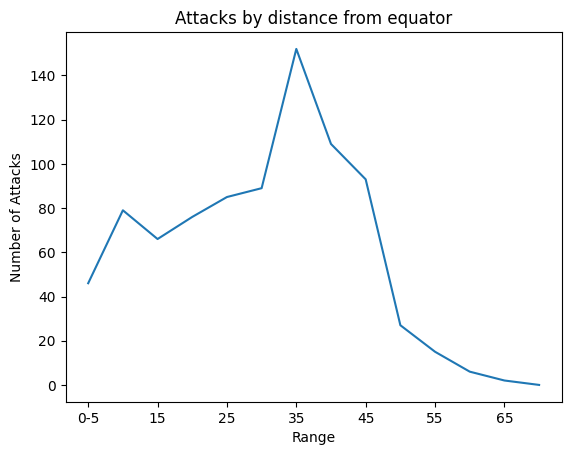

In [13]:
#create a data frame with absolute values of latitude to analyze attacks based on the distance from the equator
latitude_df = location_counts[['lat','count']].copy()
latitude_df['lat'] = latitude_df['lat'].abs()

bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
groups = ['0-5','10','15','20','25','30','35','40','45','50','55','60','65','>65']
latitude_df['Range']=pd.cut(latitude_df['lat'],bins,labels=groups,include_lowest=True)

latitude_counts = latitude_df.value_counts(['Range']).reset_index().sort_values(by="Range").set_index('Range')
latitude_counts.rename(columns={'count':'Attacks'},inplace = True)
latitude_counts.plot(kind='line',title='Attacks by distance from equator',ylabel='Number of Attacks',legend=False)
plt.savefig("Output/Distance from equator.png")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1500x480 with 0 Axes>

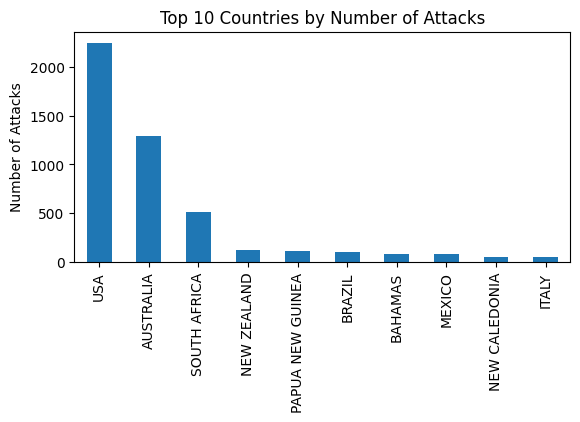

In [15]:
#create a dataframe for my country counts
country_counts = year_location_df.value_counts(['Country']).reset_index().set_index('Country')
country_counts = country_counts.head(10)

#create a graph of the values
plt.figure().set_figwidth(15)

country_counts.plot(kind='bar',title='Top 10 Countries by Number of Attacks',ylabel='Number of Attacks',xlabel='', rot=90,legend=False)
plt.subplots_adjust(bottom=0.4)
plt.savefig("Output/Country.png")
plt.show